# How does past temperature affect COVID-19 case growth?

In [1]:
import time
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import scipy

## Tunables

In [2]:
# The weather variable to observe. Try TAVG, TMIN, TMAX, PRCP (daily temperature avg/min/max, daily precipitation)
ELEMENT = 'TAVG'

In [3]:
# Require this many cumulative cases in a country to accept daily growth factors
MIN_CASES = 30

In [4]:
# The temperature we correlate with is the day's temperature compared to the mean of this long window.
# The model seems to be fairly sensitive to this? (14d gives no significant result). None = do not filter.
TEMP_SMOOTH_PERIOD = None    # '3d'

In [5]:
# Predict new cases from old cases (without weather data) from this many previous days
NUM_DIFFS_TO_USE = 2

In [6]:
NUM_CONTROL_SAMPLES = 50000  # 5000 is a reasonably fast, good number; 10x that for good results

In [7]:
# How many days' offset to consider at maximum
NUM_DAYS = 30

In [8]:
COUNTRY_COORDS = {
    'US': (40.7789, -73.9692),  # New York City
    'IT': (45.4717, 9.1892),    # Milan
    'CN': (30.6, 114.05),       # Wuhan
    'ES': (40.3, -3.723),       # Madrid
    'DE': (48.13, 11.57),       # Munich
    'FR': (48.86, 2.35),        # Paris
    'IR': (34.64, 50.876),      # Qom
    'UK': (51.507, -0.128),     # London
    'CH': (46.00, 8.95),        # Lugano
    'KR': (35.87, 128.6),       # Daegu
    'NL': (51.55, 5.08),        # Tilburg
    'AT': (48.2, 16.37),        # Vienna
    'TR': (41.01, 28.955),      # Istanbul chosen arbitrarily (no clear which cities are epicenters)
    'CA': (45.51, -73.56),      # Montreal
    'PT': (38.73, -9.15),       # Lisbon
    'NO': (59.91, 10.75),       # Oslo,
    'AU': (-37.81, 144.96),     # Melbourne
    'IL': (31.78, 35.22),       # Jerusalem
    'BR': (-23.55, -46.63),     # São Paulo
    'SE': (59.33, 18.07),       # Stockholm
    'CZ': (50.08, 14.42),       # Prague
    'IE': (53.35, -6.27),       # Dublin
    'MY': (3.15, 101.70),       # Kuala Lumpur
    'DE': (55.68, 12.57),       # Copenhagen
    'CL': (-33.45, -70.67),     # Santiago
    'LU': (49.61, 6.13),        # Luxemburg City
    'EC': (-2.18, -79.88),      # Guayaquil
    'JP': (35.69, 139.69),      # Tokyo
    'PL': (52.23, 20.02),       # Warsaw
    'RO': (44.43, 26.10),       # Bucharest
    'PK': (24.86, 67.01),       # Karachi
    'RU': (55.76, 37.62),       # Moscow
    'TH': (13.75, 100.49),      # Bangkok
    'SA': (26.56, 50.00),       # Qatif
    'ZA': (-26.20, 28.05),      # Johannesburg
    'FI': (60.1667, 24.95),     # Helsinki
}

In [9]:
STATIONS = {'US': 'USW00014732',   # New York Laguardia AP,
            'IT': 'ITM00016088',   # Ghedi
            'CN': 'CHM00057494',   # Wuhan
            'ES': 'SPE00120296',   # Madrid Getafe
            'DE': 'GMM00010870',   # Schwaigermoos, near Munich
            'FR': 'FR000007150',   # Paris Le Bourget
            'IR': 'IRM00040785',   # Kashan, near Qom
            'UK': 'UKM00003772',   # London Heathrow
            'CH': 'SZ000009480',   # Lugano
            'KR': 'KSM00047138',   # Pohang, near Daegu
            'NL': 'NLM00006260',   # de Bilt, near Tilburg
            'AT': 'AU000005901',   # Wien
            'TR': 'TUM00017064',   # Istanbul Bolge (Kartal)
            'CA': 'CA007024745',   # McTavish
            'PT': 'PO000008535',   # Lisboa Geofisica
            'NO': 'NOM00001492',   # Oslo Blindern,
            'AU': 'ASN00087031',   # Laverton RAAF
            'IL': 'ISM00040180',   # Ben Gurion
            'BR': 'BR00E3-0520',   # São Paulo aeroport
            'SE': 'SWM00002589',   # Gotska Sandön A
            'CZ': 'EZM00011520',   # Praha-Libus
            'IE': 'EI000003969',   # Dublin Phoenix Park
            'MY': 'MYM00048647',   # Sultan Abdul Aziz Shah Intl
            'CL': 'CIM00085577',   # Quinta Normal
            'LU': 'LU000006590',   # Luxembourg airport
            'EC': 'PEM00084370',   # Pedro Canga
            'JP': 'JA000047662',   # Tokyo
            'PL': 'PLM00012375',   # Okecie
            'RO': 'ROE00108889',   # Bucuresti-Baneasa
            'PK': 'PKM00041780',   # Jinnah Intl
            'RU': 'RSM00027612',   # Moscow
            'TH': 'TH000048455',   # Bangkok metropolis
            'SA': 'SAW00032502',   # Dhahran
            'ZA': 'SFM00068368',   # Johannesburg Intl
            'FI': 'FIE00142101',   # Helsinki Ilmala,
           }
assert len(set(STATIONS.values())) == len(set(STATIONS)), 'Two countries map to same station; currently this breaks our logic'

## Read temperature data

In [10]:
temps = pd.read_csv('data/2020.csv.gz', names='station date element value measure_flag quality_flag source_flag obs_time'.split(),
                    dtype={'measure_flag': str, 'quality_flag': str, 'source_flag': str, 'obs_time': str},
                    parse_dates=['date'])

In [11]:
temps = temps[temps.quality_flag.isna()].drop('quality_flag', axis=1)

## Code to allow finding good stations near the coordinates specified in STATIONS

In [12]:
temp_stations = pd.read_fwf('data/ghcnd-stations.txt', names='station lat lon elev state name gsn hcn wmo_id'.split(),
                            colspecs=[(0, 11), (12, 20), (21, 30), (31, 37), (38, 40), (41, 71), (72, 75), (76, 79), (80, 85)])

In [13]:
def haversine(lat1, lon1, lat2, lon2, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    lat1, lon1 = np.radians([lat1, lon1])
    lat2, lon2 = np.radians([lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [14]:
obs_counts = temps[temps.element==ELEMENT].groupby('station').value.count().rename('obs_count')

In [15]:
def find_nearest():
    for country, (lat, lon) in COUNTRY_COORDS.items():
        if country in STATIONS:
            continue
        stations = temp_stations.copy()
        stations['dist'] = haversine(lat, lon, stations.lat, stations.lon)
        stations = stations.sort_values('dist')
        stations = stations.merge(obs_counts, on='station').set_index('station')
        print(f'Nearest to {country}:')
        print(stations['obs_count dist elev name'.split()].iloc[:10])
        print()
        
find_nearest()

In [16]:
print(f'#{ELEMENT} observations on stations:')
els = temps[temps.element==ELEMENT]
els = els[els.station.isin(STATIONS.values())]
print(els.groupby('station').count().value)
max_measurements = els.groupby('station').count().value.max()
meas_threshold = max_measurements / 2
no_meas_countries = []
for country, station in STATIONS.items():
    if (els.station == station).sum() < meas_threshold:
        print(f'*** Less than {meas_threshold} {ELEMENT} observations in country {country} ({station}). Dropping country.')
        no_meas_countries.append(country)

for country in no_meas_countries:
    del COUNTRY_COORDS[country]
    del STATIONS[country]

#TAVG observations on stations:
station
ASN00087031    89
AU000005901    89
BR00E3-0520    89
CA007024745    90
CHM00057494    89
CIM00085577    89
EI000003969    89
EZM00011520    89
FIE00142101    89
FR000007150    89
GMM00010870    89
IRM00040785    89
ISM00040180    89
ITM00016088    89
JA000047662    89
KSM00047138    89
LU000006590    89
MYM00048647    89
NLM00006260    89
NOM00001492    89
PEM00084370    89
PKM00041780    89
PLM00012375    89
PO000008535    89
ROE00108889    89
RSM00027612    89
SAW00032502    89
SFM00068368    88
SPE00120296    89
SWM00002589    89
SZ000009480    89
TH000048455    89
TUM00017064    89
UKM00003772    89
USW00014732    90
Name: value, dtype: int64


In [17]:
temps.station = temps.station.map({v: k for k, v in STATIONS.items()})

In [18]:
temps = temps[~temps.station.isna()]

In [19]:
temps.element.value_counts()

TAVG    3116
PRCP    2244
TMIN    2035
TMAX    1828
SNWD     503
SNOW      90
WDF5      88
AWND      88
WDF2      88
WSF5      88
WSF2      88
WT01      30
WSFG      20
WDFG      20
WT08      13
WT02       4
PGTM       2
WT04       1
Name: element, dtype: int64

In [20]:
temps = temps[temps.element.isin('TMIN TMAX TAVG PRCP'.split())]

In [21]:
# The data has tenths of degrees, tenths of millimeters
temps.value /= 10

In [22]:
temps = pd.pivot_table(temps, index=['date'], columns=['element', 'station'], values='value')

## Read COVID-19 data

In [23]:
covid = pd.read_csv('data/COVID-19-geographic-disbtribution-worldwide.csv',
                   parse_dates=['dateRep'], na_values=[''], keep_default_na=False).rename(
    columns={'countryterritoryCode': 'country', 'popData2018': 'population'})

In [24]:
covid['date'] = pd.to_datetime(covid[['day', 'month', 'year']])
covid = covid['date cases deaths country population geoId'.split()]
covid = covid.pivot(index='date', columns='geoId')
covid = covid.sort_values(by='date')

The cases and deaths columns in the dataset contain new cases/deaths, not the cumulative count.

In [25]:
covid

cases                                                        ...  \
geoId         AD     AE    AF   AG   AI    AL    AM   AO     AR     AT  ...   
date                                                                    ...   
2019-12-31   NaN    0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN    0.0  ...   
2020-01-01   NaN    0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN    0.0  ...   
2020-01-02   NaN    0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN    0.0  ...   
2020-01-03   NaN    0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN    0.0  ...   
2020-01-04   NaN    0.0   0.0  NaN  NaN   NaN   0.0  NaN    NaN    0.0  ...   
...          ...    ...   ...  ...  ...   ...   ...  ...    ...    ...  ...   
2020-03-29  41.0   63.0  15.0  0.0  0.0  11.0  52.0  0.0   55.0  594.0  ...   
2020-03-30  26.0    0.0   8.0  0.0  0.0  15.0   0.0  3.0   75.0  522.0  ...   
2020-03-31  36.0  143.0  27.0  0.0  0.0  11.0  58.0  0.0  146.0  805.0  ...   
2020-04-01   6.0   53.0  25.0  0.0  0.0  20.0  50.0  0.0    0.0  564.0  ...   
2020-04-02  14.0    0.0  26.0  0.0  0.0  16.0  39.0  1.0  167.0  529.0  ...   

           population                                                       \
geoId              VA        VC          VE       VG        VI          VN   
date                                                                         
2019-12-31        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-01        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-02        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-03        NaN       NaN         NaN      NaN       NaN  95540395.0   
2020-01-04        NaN       NaN         NaN      NaN       NaN  95540395.0   
...               ...       ...         ...      ...       ...         ...   
2020-03-29     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   
2020-03-30     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   
2020-03-31     1000.0  110210.0  28870195.0  29802.0       NaN  95540395.0   
2020-04-01     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   
2020-04-02     1000.0  110210.0  28870195.0  29802.0  106977.0  95540395.0   

                                                           
geoId              XK          ZA          ZM          ZW  
date                                                       
2019-12-31        NaN         NaN         NaN         NaN  
2020-01-01        NaN         NaN         NaN         NaN  
2020-01-02        NaN         NaN         NaN         NaN  
2020-01-03        NaN         NaN         NaN         NaN  
2020-01-04        NaN         NaN         NaN         NaN  
...               ...         ...         ...         ...  
2020-03-29  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-30  1845300.0  57779622.0  17351822.0  14439018.0  
2020-03-31  1845300.0  57779622.0  17351822.0  14439018.0  
2020-04-01  1845300.0  57779622.0  17351822.0  14439018.0  
2020-04-02  1845300.0  57779622.0  17351822.0  14439018.0  

[94 rows x 816 columns]

In [26]:
covid = covid.join(covid[['cases']].cumsum().rename(columns={'cases': 'cases_cum'}))
covid = covid.join(covid[['deaths']].cumsum().rename(columns={'deaths': 'deaths_cum'}))

In [27]:
cases_cum = covid.cases_cum[covid.cases_cum >= MIN_CASES]
cases_cum = cases_cum[cases_cum.first_valid_index():]

In [28]:
def crop_series(ser):
    ser = ser[ser >= MIN_CASES]
    return ser[ser.first_valid_index():]

def plot_log(ser, label=None):
    ser[ser.first_valid_index():].plot(logy=True, label=label)

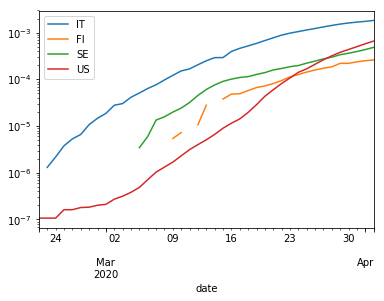

In [29]:
plot_log(cases_cum.IT/covid.population.IT)
plot_log(cases_cum.FI/covid.population.FI)
plot_log(cases_cum.SE/covid.population.SE)
plot_log(cases_cum.US/covid.population.US)

plt.legend();

## Predict new cases from case history alone

In [30]:
PRED_VARS = [f'x{n}' for n in range(1, NUM_DIFFS_TO_USE+1)]

shifted = [cases_cum] + [cases_cum.shift(freq=f'{days}d') for days in range(1, NUM_DIFFS_TO_USE+2)]
pred_data = pd.concat([cases_cum] + [a/b for a, b in zip(shifted, shifted[1:])],
                      keys=['cases_cum', 'y'] + PRED_VARS,
                      axis=1).stack().dropna()

In [31]:
pred_data

cases_cum         y        x1        x2
date       geoId                                         
2020-01-06 CN          59.0  1.000000  1.340909  1.000000
2020-01-07 CN          59.0  1.000000  1.000000  1.340909
2020-01-08 CN          59.0  1.000000  1.000000  1.000000
2020-01-09 CN          59.0  1.000000  1.000000  1.000000
2020-01-10 CN          59.0  1.000000  1.000000  1.000000
...                     ...       ...       ...       ...
2020-04-02 UZ         187.0  1.080925  1.161074  1.027586
           VE         143.0  1.059259  1.000000  1.134454
           VN         235.0  1.026201  1.000000  1.004386
           XK         112.0  1.000000  1.056604  1.232558
           ZA        1380.0  1.019956  1.020362  1.035937

[2217 rows x 4 columns]

In [32]:
# A better predictor would make this... better.
regr = LinearRegression().fit(pred_data[PRED_VARS], pred_data.y.to_numpy().reshape(-1, 1))

## Compute the residual of our cases-history-only prediction and the known true cases value

In [33]:
pred_data['y_pred'] = regr.predict(pred_data[PRED_VARS])
pred_data['y_residual'] = pred_data.y - pred_data.y_pred
pred_data.y_residual -= pred_data.y_residual.mean()
pred_data['cases_cum_pred'] = pred_data.cases_cum / pred_data.y * pred_data.y_pred

pred_data = pred_data.unstack()

pred_data

cases_cum                                                     \
geoId             CN JPG11668      SG      TH      JP      KR        US   
date                                                                      
2020-01-06      59.0      NaN     NaN     NaN     NaN     NaN       NaN   
2020-01-07      59.0      NaN     NaN     NaN     NaN     NaN       NaN   
2020-01-08      59.0      NaN     NaN     NaN     NaN     NaN       NaN   
2020-01-09      59.0      NaN     NaN     NaN     NaN     NaN       NaN   
2020-01-10      59.0      NaN     NaN     NaN     NaN     NaN       NaN   
...              ...      ...     ...     ...     ...     ...       ...   
2020-03-29   82059.0      NaN   803.0  1245.0  1693.0  9583.0  124665.0   
2020-03-30   82157.0      NaN   844.0  1388.0  1866.0  9661.0  143025.0   
2020-03-31   82241.0      NaN   844.0  1651.0  1953.0  9786.0  164620.0   
2020-04-01   82295.0      NaN   879.0  1651.0  1953.0  9786.0  189618.0   
2020-04-02   82395.0      NaN  1000.0  1771.0  2178.0  9976.0  216721.0   

                                      ... cases_cum_pred             \
geoId             IT       IR     TW  ...             PF         GT   
date                                  ...                             
2020-01-06       NaN      NaN    NaN  ...            NaN        NaN   
2020-01-07       NaN      NaN    NaN  ...            NaN        NaN   
2020-01-08       NaN      NaN    NaN  ...            NaN        NaN   
2020-01-09       NaN      NaN    NaN  ...            NaN        NaN   
2020-01-10       NaN      NaN    NaN  ...            NaN        NaN   
...              ...      ...    ...  ...            ...        ...   
2020-03-29   92472.0  35408.0  283.0  ...            NaN        NaN   
2020-03-30   97689.0  38309.0  306.0  ...      37.852037        NaN   
2020-03-31  101739.0  41495.0  306.0  ...      39.267377  40.040905   
2020-04-01  105792.0  44606.0  322.0  ...      39.565487  39.593878   
2020-04-02  110574.0  47593.0  339.0  ...      40.651934  41.721693   

                                                                              \
geoId               PR         IM         JM         UG         BB        MG   
date                                                                           
2020-01-06         NaN        NaN        NaN        NaN        NaN       NaN   
2020-01-07         NaN        NaN        NaN        NaN        NaN       NaN   
2020-01-08         NaN        NaN        NaN        NaN        NaN       NaN   
2020-01-09         NaN        NaN        NaN        NaN        NaN       NaN   
2020-01-10         NaN        NaN        NaN        NaN        NaN       NaN   
...                ...        ...        ...        ...        ...       ...   
2020-03-29         NaN        NaN        NaN        NaN        NaN       NaN   
2020-03-30         NaN        NaN        NaN        NaN        NaN       NaN   
2020-03-31  160.431910        NaN        NaN        NaN        NaN       NaN   
2020-04-01  212.116462  48.521971  42.706721  36.591434        NaN       NaN   
2020-04-02  296.748577  58.966892  42.282185  50.722402  37.182237  52.31593   

                                  
geoId              SV         TG  
date                              
2020-01-06        NaN        NaN  
2020-01-07        NaN        NaN  
2020-01-08        NaN        NaN  
2020-01-09        NaN        NaN  
2020-01-10        NaN        NaN  
...               ...        ...  
2020-03-29        NaN        NaN  
2020-03-30        NaN        NaN  
2020-03-31        NaN        NaN  
2020-04-01        NaN        NaN  
2020-04-02  35.249424  37.948019  

[88 rows x 931 columns]

## Some plots to show how our predictor works

In [34]:
def plot_pred(data, country):
    plot_log(pred_data.cases_cum[country], f'{country} real')
    plot_log(pred_data.cases_cum_pred[country], f'{country} pred')
    plt.legend()
    print(f'log-loss: {(pred_data.y[country]-pred_data.y_pred[country]).pow(2).mean()}')

log-loss: 0.012266306753552399


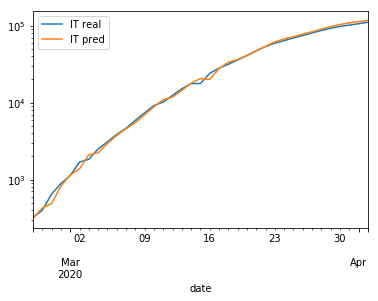

In [35]:
plot_pred(pred_data, 'IT')

log-loss: 0.0033472318124445235


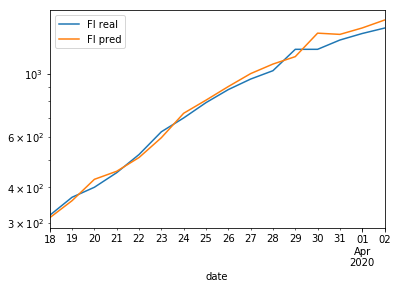

In [36]:
plot_pred(pred_data, 'FI')

log-loss: 0.008941965981430869


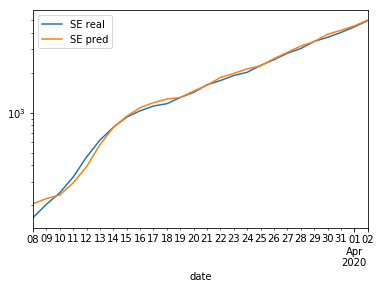

In [37]:
plot_pred(pred_data, 'SE')

log-loss: 0.03983882543751733


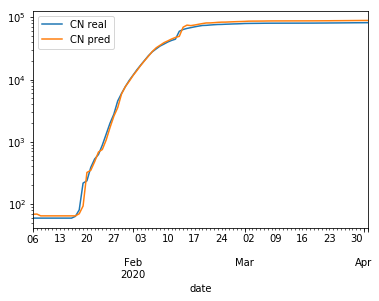

In [38]:
plot_pred(pred_data, 'CN')

In [39]:
# Copy temperature data to pred_data
for country in STATIONS:
    for elem in 'TAVG TMIN TMAX PRCP'.split():
        try:
            pred_data[elem, country] = temps[elem, country]
        except KeyError:
            pred_data[elem, country] = np.nan

## The per-country correlation is messy

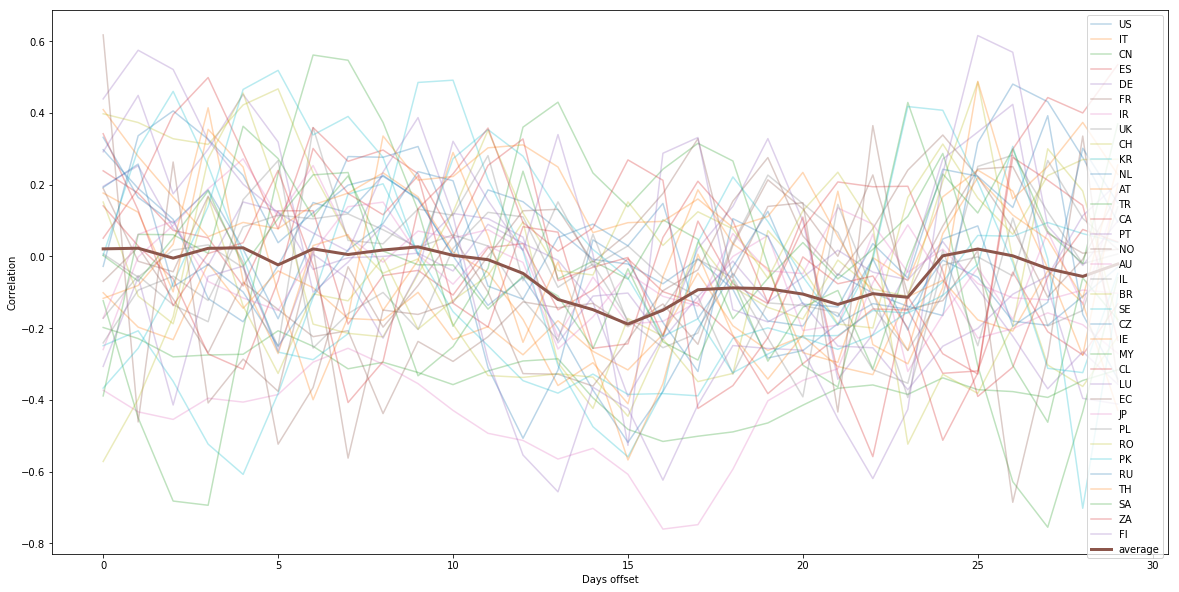

In [40]:
# TODO: A matshow plot would probably demonstrate this better

plt.figure(figsize=(20, 10))
all_countries = []
for country in STATIONS:
    a = []
    for days in range(NUM_DAYS):
        a.append(pred_data[ELEMENT, country].shift(freq=f'{days}d').corr(pred_data.y_residual[country]))
    a = np.array(a)
    all_countries.append(a)
    plt.plot(range(NUM_DAYS), a, label=country, alpha=.3)
all_countries = np.array(all_countries)
plt.plot(range(NUM_DAYS), np.mean(all_countries, axis=0), label='average', linewidth=3)
plt.xlabel('Days offset')
plt.ylabel('Correlation')
plt.legend();

## Calculate a correlation matrix of daily new cases in country Y vs temperature in country X, for each of the day offsets.

In [41]:
def calc_corr():
    '''Returns a dataframe indexed by (cases_country, days) with (temp_country) as columns.'''
    a = []
    if TEMP_SMOOTH_PERIOD is not None:
        # high pass filter    
        temp_smoothed = pred_data[ELEMENT].rolling(TEMP_SMOOTH_PERIOD).mean()
    else:
        temp_smoothed = pred_data[ELEMENT]
    countries = list(temp_smoothed.columns)
    for days in range(0, NUM_DAYS):
        temp_shifted = temp_smoothed.shift(freq=f'{days}d')
        for temp_country in countries:
            for cases_country in countries:
                c = temp_shifted[cases_country].corr(pred_data.y_residual[temp_country])
                a.append((cases_country, days, temp_country, c))
    a = np.array(a)
    return pd.DataFrame(dict(
        cases_country=a[:, 0].astype(str),
        days=a[:, 1].astype(int),
        temp_country=a[:, 2].astype(str),
        corr_=a[:, 3].astype(float))).set_index(['cases_country', 'days']).pivot(columns='temp_country')

In [42]:
corr_mtx = calc_corr()

In [43]:
corr_mtx

corr_                                          \
temp_country              AT        AU        BR        CA        CH   
cases_country days                                                     
AT            0     0.409044 -0.281456  0.262008 -0.154183  0.117867   
              1     0.278595 -0.035735  0.170785 -0.230219  0.106835   
              2     0.164699  0.243147  0.071270 -0.025226  0.077015   
              3     0.054862  0.385544  0.211529 -0.054084  0.035232   
              4     0.094622  0.120851  0.288564 -0.036245  0.149895   
...                      ...       ...       ...       ...       ...   
ZA            25    0.340500  0.377561  0.131664  0.108790 -0.048900   
              26    0.590464  0.181844 -0.011946  0.019634  0.163191   
              27    0.463471  0.163536  0.139787  0.253394  0.107485   
              28    0.250067  0.244239  0.346096  0.430062 -0.030120   
              29    0.178951  0.161070  0.149143  0.294226  0.116609   

                                                                      ...  \
temp_country              CL        CN        CZ        DE        EC  ...   
cases_country days                                                    ...   
AT            0     0.040816 -0.204907  0.359915  0.260846 -0.039439  ...   
              1     0.034718 -0.284560  0.137215  0.249985  0.339540  ...   
              2    -0.108295 -0.268187  0.057687  0.216777  0.137466  ...   
              3    -0.086362 -0.275011  0.121185  0.059103  0.357667  ...   
              4     0.107439 -0.319408  0.035197  0.088172  0.065631  ...   
...                      ...       ...       ...       ...       ...  ...   
ZA            25    0.190587  0.104647 -0.053194 -0.010398  0.091816  ...   
              26    0.222472  0.107591  0.090692 -0.012026  0.014489  ...   
              27    0.088265  0.187796  0.303541 -0.017827 -0.109973  ...   
              28    0.219061  0.135441  0.345392  0.137556  0.077546  ...   
              29    0.352415  0.097140  0.313747  0.271504  0.256207  ...   

                                                                      \
temp_country              PT        RO        RU        SA        SE   
cases_country days                                                     
AT            0     0.247048 -0.506270  0.131601 -0.088019  0.432032   
              1     0.259366 -0.418193  0.136376 -0.032891  0.394364   
              2     0.205781 -0.414949  0.040054  0.136805  0.094553   
              3     0.271614 -0.167400  0.008926  0.018531 -0.019437   
              4     0.188281  0.245050 -0.310885  0.107456 -0.118621   
...                      ...       ...       ...       ...       ...   
ZA            25    0.386504  0.106274 -0.041181  0.019841  0.273518   
              26    0.466315  0.434834 -0.190168 -0.099717  0.381080   
              27    0.531398  0.270656 -0.187572  0.108263  0.242083   
              28    0.440181 -0.149023  0.151086  0.262386  0.060997   
              29    0.321203 -0.052135  0.259407 -0.056433 -0.045085   

                                                                      
temp_country              TH        TR        UK        US        ZA  
cases_country days                                                    
AT            0    -0.158975  0.702985 -0.044688  0.342615 -0.141977  
              1     0.274710  0.490348  0.064585  0.107065 -0.238322  
              2     0.352308  0.066740  0.119233  0.196564 -0.487779  
              3     0.331376 -0.226135  0.211400 -0.029199 -0.287487  
              4     0.185662 -0.420473 -0.004907 -0.044555  0.066245  
...                      ...       ...       ...       ...       ...  
ZA            25   -0.004553 -0.386491 -0.131372 -0.103425 -0.325261  
              26   -0.123189 -0.471285 -0.133933 -0.082297  0.298601  
              27   -0.232146 -0.334230  0.221755 -0.073084  0.442712  
              28   -0.100090  0.158640  0.253651 -0.144543  0.399711  
   

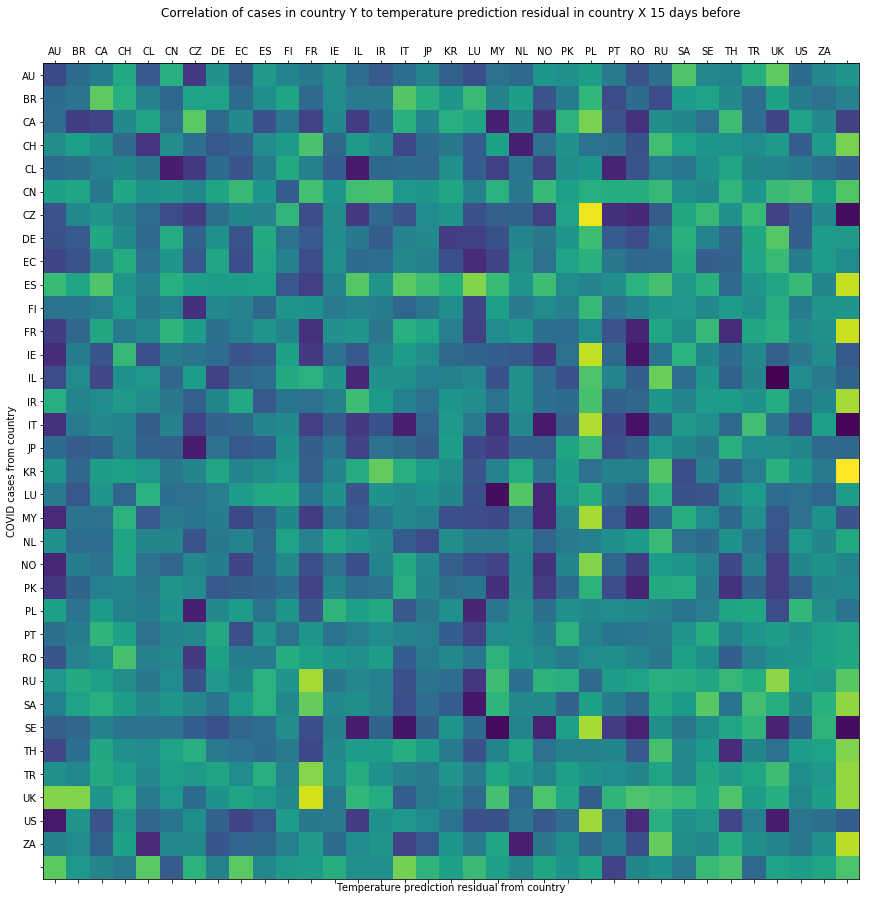

In [44]:
CORR_MTX_PLOT_DAY = 15
fig, ax = plt.subplots(figsize=(15, 15))
ax.matshow(corr_mtx.loc(axis=0)[:, CORR_MTX_PLOT_DAY])
ax.set_xlabel('Temperature prediction residual from country')
ax.set_ylabel('COVID cases from country')
ax.set_xticklabels(corr_mtx.corr_.columns)
ax.set_yticklabels(corr_mtx.corr_.columns)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.set_title(f'Correlation of cases in country Y to temperature prediction residual in country X {CORR_MTX_PLOT_DAY} days before');

In [45]:
def np_dropna(a):
    '''Drop nan values from a 1-dimensional numpy array.'''
    assert len(a.shape) == 1, a.shape
    return a[~np.isnan(a)]

## Generate control data by correlating COVID cases with temperatures in random stations

In [46]:
def calc_control_data():
    '''Returns something of the form (days, *)'''
    # TODO: Vectorize this
    # TODO: should we weigh countries equally or by the number of valid days?
    # samples_by_country = pred_data.cases_cum.count()
    a = []
    countries = list(corr_mtx.corr_.columns)
    for i in range(NUM_CONTROL_SAMPLES):
        if i % 5000 == 0:
            print(i, time.asctime(), flush=True)
        random.shuffle(countries)
        a.append(corr_mtx.corr_[countries].groupby('days').apply(np.diag).apply(np_dropna).apply(np.mean).to_numpy())
    return np.array(a).T

In [47]:
control_data = calc_control_data()

0 Thu Apr  2 19:42:16 2020
5000 Thu Apr  2 19:42:50 2020
10000 Thu Apr  2 19:43:24 2020
15000 Thu Apr  2 19:44:02 2020
20000 Thu Apr  2 19:44:41 2020
25000 Thu Apr  2 19:45:16 2020
30000 Thu Apr  2 19:45:51 2020
35000 Thu Apr  2 19:46:27 2020
40000 Thu Apr  2 19:47:03 2020
45000 Thu Apr  2 19:47:39 2020


## Compare correlation of the same country cases and temperature to the control data

In [48]:
def calc_corr_quantiles():
    q = np.quantile(control_data, q=[0.025, 0.5, 0.975], axis=1)
    return pd.DataFrame({'day': range(q.shape[1]), 'lo': q[0], 'median_': q[1], 'mean_': control_data.mean(axis=1), 'hi': q[2]}).set_index('day')

def quantile_of_score_over_index(series, ctrl):
    s = series.copy()
    for i in s.index:
        s[i] = scipy.stats.percentileofscore(ctrl[i], s[i])/100.0
    return s

def plot_corr(quantiles=False):
    def map_(ser):
        if quantiles:
            return quantile_of_score_over_index(ser, control_data)
        return ser

    corr_quantiles = calc_corr_quantiles()

    a = map_(corr_mtx.corr_.groupby('days').apply(np.diag).apply(np_dropna).apply(np.mean))
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(True, which='both', axis='both')
    a.plot(label='correlation', style='-x')
    median_ = map_(corr_quantiles.median_)
    mean_ = map_(corr_quantiles.mean_)
    lo, hi = map_(corr_quantiles.lo), map_(corr_quantiles.hi)
    if quantiles:
        ax.set_yscale('logit')
        ax.set_ylabel('p value (not multiplicity corrected)')
        for x, y in a.iteritems():
            ax.annotate(f'{y:.3g}', xy=(x, y))
    else:
        ax.set_ylabel('correlation')
        
    ax.plot(corr_quantiles.index, mean_, '--', label='control median')
    ax.plot(corr_quantiles.index, median_, '--', label='control mean')
    ax.fill_between(corr_quantiles.index, lo, hi, alpha=.2)
    ax.set_title(f'Correlation of COVID-19 daily growth factor vs estimate and past daily {ELEMENT}')
    ax.set_xlabel('Offset (days)')
    ax.legend()

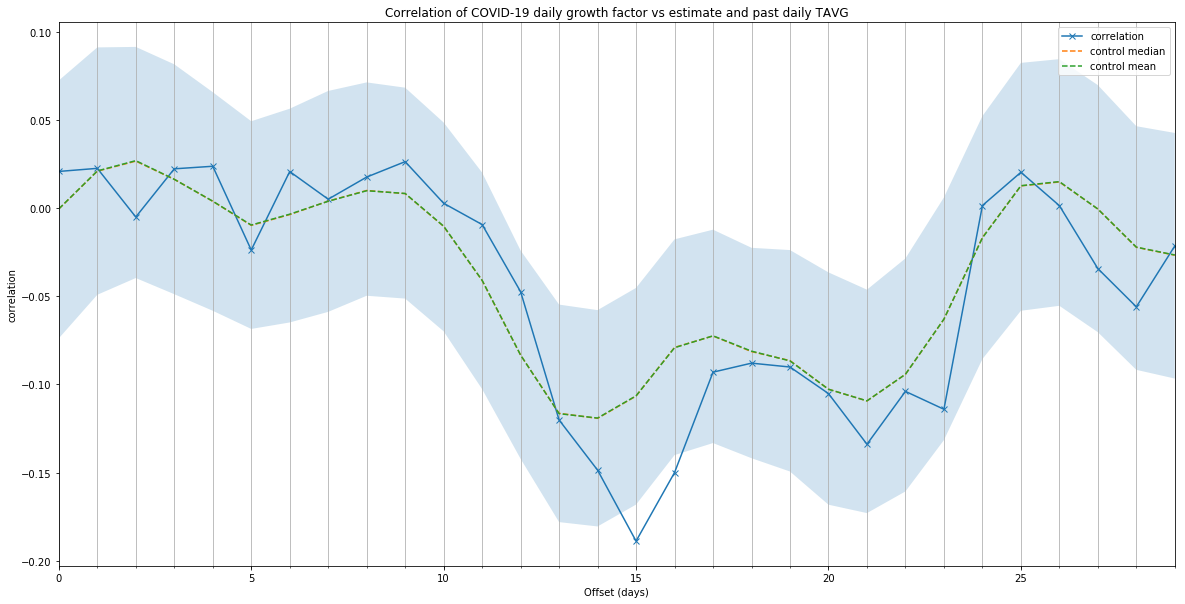

In [49]:
plot_corr(quantiles=False)

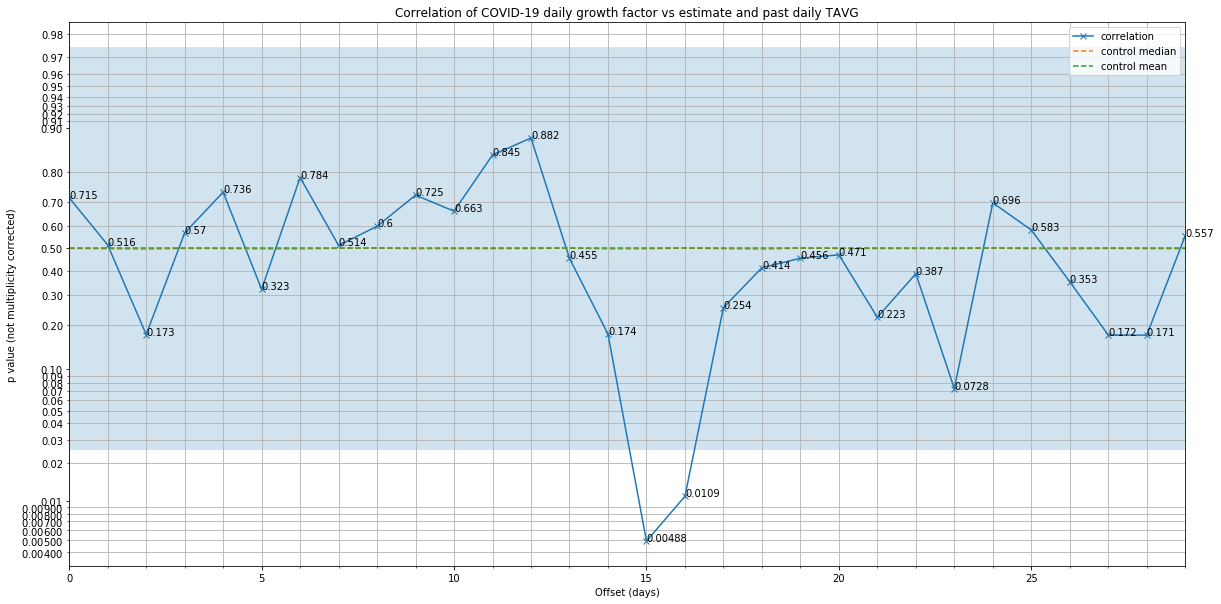

In [50]:
plot_corr(quantiles=True)